In [30]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)    # 设置显示最大行数
pd.set_option('display.max_columns', 100)  # 设置显示最大列数

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
#一个魔法函数,可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
%matplotlib inline  

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    # 绘制特征重要性曲线
    fig, ax = plt.subplots(1,1,figsize=figsize)  #通过plt控制子图
    return plot_importance(booster=booster, ax=ax,max_num_features=80)   #booster : model，ax :设置画布大小的时候用

import time
import sys
import gc
import pickle
sys.version_info   #查询当前python版本号

sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)

In [21]:
#读取数据
items = pd.read_csv('items.csv')   #商品的补充数据集（包含商品名称和所属分类字段）
shops = pd.read_csv('shops.csv')    #商店信息的补充数据集（包含商店所在城市和商店规模的信息）
cats = pd.read_csv('item_categories.csv')   #商品类目的补充数据集（包含商品所属类目的详细信息）
train = pd.read_csv('sales_train.csv')  #训练集（包含2013年1月至2015年10月间每天各商店各商品的销量）
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')   #测试集（需要预测的接下来的2015年11月份的各商店的商品销量）

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<AxesSubplot:xlabel='item_price'>

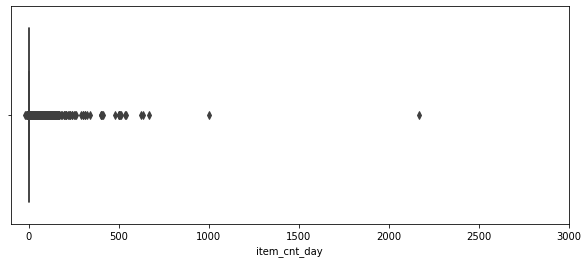

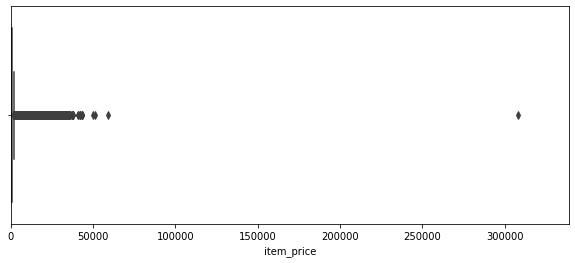

In [84]:
plt.figure(figsize=(10,4))  #生成了一个画板
plt.xlim(-100, 3000)   #显示的是x轴的作图范围
sns.boxplot(x=train.item_cnt_day)  #箱形图

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [86]:
#异常值处理，去除商品价格>100000和单日销量>10001的数据
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
print(train[(train.shop_id==0)])
# sum of the sales

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
37589   12.01.2013               0        0    11059        73.0           1.0
37590   22.01.2013               0        0    11059        73.0           1.0
37591   26.01.2013               0        0    11059        73.0           1.0
37592   12.01.2013               0        0    11347       170.0           1.0
37593   22.01.2013               0        0    11347       170.0           1.0
...            ...             ...      ...      ...         ...           ...
183257  22.02.2013               1        0    13460      1228.0           2.0
183258  21.02.2013               1        0    13460      1228.0           1.0
183259  20.02.2013               1        0    13460      1228.0           1.0
183260  17.02.2013               1        0    13460      1228.0           1.0
183261  16.02.2013               1        0    12607        76.0           1.0

[9857 rows x 6 columns]


In [5]:
#有一件商品的价格小于0，用中位数填充
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()  #选取相同商店和相同商品id和相同月份的商品价格数据求中位数
train.loc[train.item_price<0, 'item_price'] = median  #选取item-price所有行，取价格<0的数据

In [77]:
#几家商店根据它们的名称发现互相重复，修复训练集和测试集
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57   #替换
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [90]:
#shops/cats/items预处理
#每个商店名以城市名开头
#每个类别名称中包含类型和子类型
#将一些低级类别特征（如城市、类型、子类型）进行一次性编码是合理的，因为 xgb 将标签编码的特征处理为数字特征。避免创建更多的特征列
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'  #同一个商店。两种名称的处理
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])   #返回城市的list
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'   #城市名处理
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])    #标准化编码，
shops = shops[['shop_id','city_code']]    #shop_name转化为city编码

#先拆分大类
cats['split'] = cats['item_category_name'].str.split('-')  
cats['type'] = cats['split'].map(lambda x: x[0].strip()) #去除空格
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# 再拆分子类
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)  #删除商品名称列，商品类别特征已经通过item-category得到

In [8]:
#测试集是一些商店和商品在34个月内的数据。5100件商品* 42家店铺= 214200组合。与训练集相比，有363个商品是新的。
# 因此，对于测试集中的大多数商品，目标值应该为零。另一方面，训练集只包含过去出售或退回的组合。
# 主要的想法是计算每月的销售额，并将每一个特别的组合扩展为零销售额。这样，训练数据就会类似于测试数据。
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test) #intersection：求交集
#找到test里面有363新的id，训练集的总的商品数5100 ，总共的商品-商店组合数214200

(363, 5100, 214200)

In [96]:
ts = time.time()  #获取当前模块运行时间
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i] #分开各个月份的销售额，date_block_num与ID联动，用来区分每个月
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16')) #product产生相应的商品-商店对
#dtype：指定类型，节省了所需的内存和计算资源
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)#按行融合，构造与test相同的集合
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts  #获取当前模块运行时间

9.675060510635376

In [101]:
#通过聚合商店/商品组合对训练集来计算目标聚集，然后对目标值以（0，20）剪切-------（0,20）根据evaluation要求
#item_cnt_month使用float代替int，避免连接test时向下转换。如果是int16，在与NaN值连接后，将变成int64.如果是float16，连接后将不变
train['revenue'] = train['item_price'] *  train['item_cnt_day']  #计算利润

In [99]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']}) #groupby聚合，agg统计计算
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)#数据清洗时,会将带空值的行删除,此时DataFrame或Series类型的数据不再是连续的索引,可以使用reset_index()重置索引。
matrix = pd.merge(matrix, group, on=cols, how='left')#同时存在三个key的值才能合并
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) #  # 小于0的设为0，大于20的设为20,大于20的设为20,总共3
                                .astype(np.float16))
time.time() - ts

4.8712592124938965

In [104]:
#设置测试集
test['date_block_num'] = 34
#指定类型，节省了所需的内存和计算资源
test['date_block_num'] = test['date_block_num'].astype(np.int8)#给test集合增加date_block_num特征第34个月份
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [108]:
#把测试集加到matrix上
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month,填充缺失值
time.time() - ts

0.8454201221466064

In [14]:
#Shops/Items/Cats features
#需要将各个数据集以及构造出来的特征合并起来，
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')  #类似于sql中jion字段
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.781156063079834

In [116]:
#滞后特征，预测零销售额
#有时候将某个特征滞后一定时间后， 得到一个新的特征， 可能会与目标变量有更强的相关性
#我们思考“今天跟昨天一样”就是滞后，能帮助获取变量的时间趋势
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [1]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

NameError: name 'time' is not defined

In [ ]:
#目标值处理
#均值化处理特征
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}) #对item_cnt_month进行操作
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt') #增加一行date_num最后的平均值，为上个data_num的值
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)#删除均值类，变成具有标注后的列
time.time() - ts

MemoryError: Unable to allocate 586. MiB for an array with shape (2, 38432886) and data type int64

In [18]:
#同理，继续按照不同的聚合来产生均值来增加特征。
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.4779634475708

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.25940179824829

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.358620643615723

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.397453308105469

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.591091632843018

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.249090194702148

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.407493114471436

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.877360582351685

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.13223147392273

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.311386346817017

In [28]:
#趋势化处理特征
#同样的为增加特征:不同聚合类型的item_price
#过去六个月的价格趋势
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)  #apply的返回值就是函数的返回值
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

175.95996284484863

In [29]:
#上个月商店利润趋势
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

18.391879558563232

In [30]:
#处理特殊的特征
#月份
matrix['month'] = matrix['date_block_num'] % 12

In [31]:
#一个月的天数，没有闰年
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [32]:
#商品新旧程度
#每个商店/商品组合和仅商品的最后一次销售后的月份
#创建hashtable，key={shop_id,item_id} ，value={date_block_num}，遍历行，如果key存在，则计算cached value和row.row.date_block_num的差值
#如果key不存在，添加到表中，并设置value=row.date_block_num
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

675.9820508956909

In [33]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

440.8247628211975

In [34]:
#每个商店/商品组合和仅商品的第一次销售后的月份，计算周期
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.0985491275787354

In [35]:
#由于使用 12 作为滞后值下降前 12 个月。同时删除了所有本月计算值的列（也就是说不能为测试集计算）
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.2304081916809082

In [36]:
#滞后会产生许多空值，需要填充
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.4332232475280762

In [37]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [38]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [39]:
#生成数据
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();#垃圾回收，试验代码时c盘快炸了，就非常需要这个

In [46]:
import pandas as pd
data = pd.read_pickle('data.pkl')

In [47]:
#搭建模型
#特征选择
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [48]:
#验证策略是测试集第34个月，验证集第33个月，训练集13月到33月
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)#数据切分
Y_train = data[data.date_block_num < 33]['item_cnt_month']    #item_cnt_month标签
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [50]:
del data
gc.collect();

In [54]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,  #最大树深
    n_estimators=1000,   # # 使用多少棵树来拟合，也可以理解为多少次迭代
    min_child_weight=300,    #叶子节点最小样本数
    colsample_bytree=0.8,     #每次拟合一棵树之前，决定使用多少个特征
    subsample=0.8,     #指定采样出 subsample * n_samples 个样本用于训练弱学习器
    eta=0.3,      #学习速度 
    seed=42)    #指定随机数种子

model.fit(
    X_train,  #输入
    Y_train,  #输出
    eval_metric="rmse",    #评估函数，evaluation要求使用rmse  ||回归任务(默认rmse)rmse--均方根误差
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],    #用于评估的数据集
    verbose=True,    #日志显示
    early_stopping_rounds = 10)   #代表在10个迭代内结果没什么改进就停止

time.time() - ts

[0]	validation_0-rmse:1.06083	validation_1-rmse:1.04809
[1]	validation_0-rmse:0.96667	validation_1-rmse:0.97946
[2]	validation_0-rmse:0.91299	validation_1-rmse:0.94495
[3]	validation_0-rmse:0.88253	validation_1-rmse:0.93073
[4]	validation_0-rmse:0.86378	validation_1-rmse:0.92072
[5]	validation_0-rmse:0.85225	validation_1-rmse:0.91671
[6]	validation_0-rmse:0.84473	validation_1-rmse:0.91447
[7]	validation_0-rmse:0.83879	validation_1-rmse:0.91215
[8]	validation_0-rmse:0.83445	validation_1-rmse:0.91241
[9]	validation_0-rmse:0.83132	validation_1-rmse:0.91174
[10]	validation_0-rmse:0.82798	validation_1-rmse:0.91190
[11]	validation_0-rmse:0.82605	validation_1-rmse:0.91134
[12]	validation_0-rmse:0.82412	validation_1-rmse:0.91156
[13]	validation_0-rmse:0.82261	validation_1-rmse:0.91065
[14]	validation_0-rmse:0.82136	validation_1-rmse:0.91168
[15]	validation_0-rmse:0.81953	validation_1-rmse:0.91232
[16]	validation_0-rmse:0.81856	validation_1-rmse:0.91262
[17]	validation_0-rmse:0.81744	validation

53.283385038375854

In [52]:
#预测
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# 保存预测文件并序列化
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

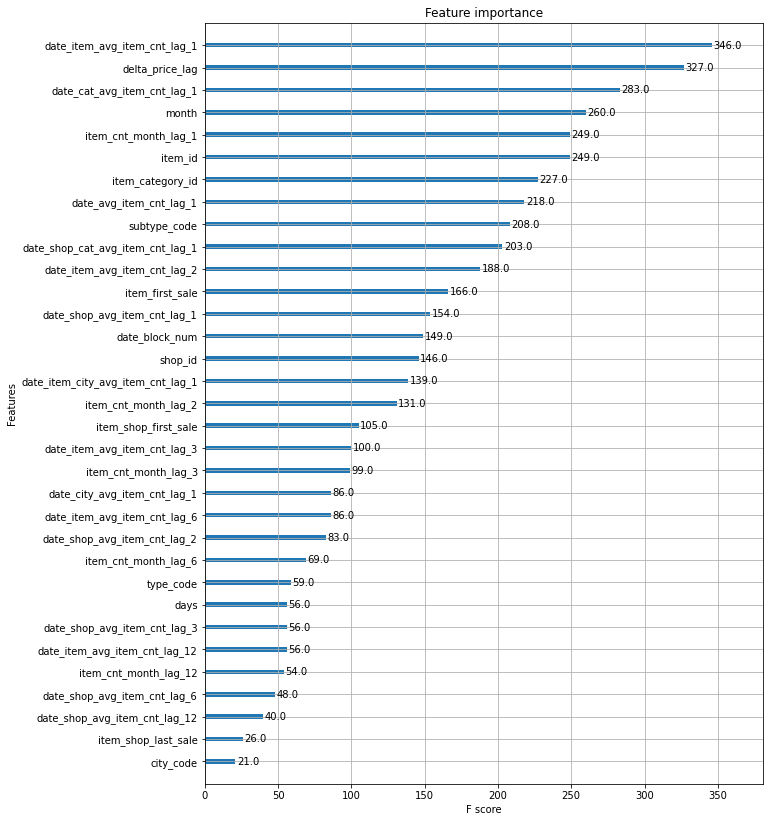

In [53]:
#特征重要性画图
plot_features(model, (10,14))